In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype']=42
from matplotlib.patches import Patch
import numpy as np
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap

FIG_DIR=Path("/lab/solexa_sun/lab_members/sdavenport/scRNAseq/brain/figures/panel2")
FIG_DIR.mkdir(parents=True, exist_ok=True)

Barplot for each cell type with number of gene modules as a bar (5 bars back to back) (colored by if disease related or not) (x axis as cell type and y axis as number of gene modules)

In [3]:
folder='/lab/solexa_sun/lab_members/sdavenport/scRNAseq/brain/co-expression_analysis/results/'

In [4]:
broad_colors={
        'Excitatory neurons':'#006d2c', #deep green
        'OPCs + COPs': '#8c510a', #brown
        'Vascular Cells': '#bebada', #purple
        'Astrocytes': '#FF7518', #orange
        'Inhibitory neurons': '#377eb8', #blue
        'Oligodendrocytes': '#f781bf', #soft pink
        'Microglia': '#e41a1c' #red
        }

In [5]:
celltypes=['Excitatory_neurons', 'OPCs_COPs', 'Vascular_Cells', 'Astrocytes', 'Inhibitory_neurons', 'Oligodendrocytes','Microglia']
datasets=['AD', 'ASD', 'BD','MS', 'SZ']

In [6]:
def get_panel2B_df(datasets=['AD', 'ASD', 'BD','MS', 'SZ'], celltypes=['Excitatory_neurons', 'OPCs_COPs', 'Vascular_Cells', 'Astrocytes', 'Inhibitory_neurons', 'Oligodendrocytes','Microglia'], folder='/lab/solexa_sun/lab_members/sdavenport/scRNAseq/brain/co-expression_analysis/results/'):
    c_df=pd.DataFrame(columns=["dataset", "celltype", "n_modules", "n_disease_modules"])
    for dataset in datasets:
        for celltype in celltypes:
            cur_modules=pd.read_csv(folder+dataset+'__'+celltype+'/modules/modules.csv')
            linear_cov=pd.read_csv(folder+dataset+'__'+celltype+'/'+dataset+'__'+celltype+'_module_covadjust.csv')
            ks=pd.read_csv(folder+dataset+'__'+celltype+'/module_geneexp_dist/'+dataset+'_KSstats.csv')
            fisher=pd.read_csv(folder+dataset+'__'+celltype+'/DEG_mod_association/'+dataset+'_fisherstats.csv')
            cur_modules=cur_modules[['module']].drop_duplicates()
            if len(linear_cov)>0:
                linear_cov=linear_cov[['module', 'p_adj']].rename(columns={'p_adj': 'linear_p_adj'})
                merged=cur_modules.merge(linear_cov, on='module', how='left')
            else:
                merged['linear_p_adj']=100
            if len(ks)>0:
                ks=ks[['module', 'median_ks_pval', 'confidence']].rename(columns={'confidence': 'ks_confidence'})
                merged=merged.merge(ks, on='module', how='left')
            else:
                merged['median_ks_pval']=100
                merged['ks_confidence']=-1
            if len(fisher)>0:
                fisher=fisher[['module', 'p_adj']].rename(columns={'p_adj': 'fisher_p_adj'})
                merged=merged.merge(fisher, on='module', how='left')
            else:
                merged['fisher_p_adj']=100
            disease_modules=(merged[['linear_p_adj', 'median_ks_pval', 'fisher_p_adj']].lt(0.05)
                             .sum(axis=1)
                             .ge(2)                 #True if >= 2 methods
                            ).sum()
            c_df.loc[len(c_df)]=[dataset, celltype, len(cur_modules.module.drop_duplicates()), disease_modules]
    return(c_df)

In [7]:
B_celltype_df=get_panel2B_df(datasets=['AD', 'ASD', 'BD','MS', 'SZ'])

In [8]:
dataset='AD'
celltype='Excitatory_neurons'
cur_modules=pd.read_csv(folder+dataset+'__'+celltype+'/modules/modules.csv')
cur_modules.module.unique()

array([1, 3, 4, 2])

In [9]:
def panel1D_barplot(dataset, df, col, order, save_plot=None, save_pdf=None, y_max=200, show=True, proportion=False):
    #plt.rcParams['pdf.fonttype']=42 #pdf editable
    conditions=df['Condition'].unique()
    non_control=[c for c in conditions if c!='Control']
    condition_order=non_control+['Control']
    df['Condition']=pd.Categorical(df['Condition'], categories=condition_order, ordered=True)

    if proportion:
        total_counts=df.groupby('Condition', observed=False)['Count'].sum().to_dict()
        df=df.copy()
        df['Count']=df.apply(lambda x: (x['Count']/total_counts[x['Condition']]) * 100, axis=1)
        y_max=100
        y_label='Percent of Cells'
    else:
        y_label='Number of Cells'

    fig,ax=plt.subplots(figsize=(12, 12))
    
    #Group and plot stacked bars per condition
    bottoms={cond: 0 for cond in df['Condition'].unique()}
    
    for subtype in order:
        subset=df[df[col]==subtype]
        for cond in df['Condition'].cat.categories:
            value=subset.loc[subset['Condition']==cond, 'Count']
            height=value.iloc[0] if not value.empty else 0
            ax.bar(cond, height, bottom=bottoms[cond], color=color_map[subtype])
            bottoms[cond]+=height
    ax.set_ylim(0, y_max)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Condition', fontsize=12)
    ax.set_title(f'{dataset}: Cell Counts per Condition', fontsize=14)
    legend_elements=[Patch(facecolor=color_map[s], label=s) for s in order if s in color_map]
    if col=='Celltype_Class':
        legend=ax.legend(handles=legend_elements,title='Cell Type',loc='center left',bbox_to_anchor=(1.02, 0.5),
                       fontsize=10,title_fontsize=9,ncol=1)
    else:
        legend=ax.legend(handles=legend_elements,title='Subtype',loc='center left',bbox_to_anchor=(1.02, 0.5),
                       fontsize=8,title_fontsize=9,ncol=1)
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    plt.tight_layout()
    if save_plot!=None:
        plt.savefig(save_plot)
    if save_pdf!=None:
        plt.savefig(save_pdf, format="pdf", bbox_inches="tight")
    if show==True:
        return(plt.show())
    else:
        plt.close(fig)
        return(print('done'))

In [10]:
celltype_order=['Excitatory_neurons', 'Inhibitory_neurons', 'Astrocytes', 'OPCs_COPs', 'Oligodendrocytes', 'Microglia', 'Vascular_Cells']
subtype_order=['Exc L2-3 CBLN2 LINC02306','Exc L3-4 RORB CUX2','Exc L3-5 RORB PLCH1','Exc L4-5 RORB GABRG1','Exc L4-5 RORB IL1RAPL2',
 'Exc L5 ET','Exc L5-6 RORB LINC02196','Exc L5/6 IT Car3','Exc L5/6 NP','Exc L6 CT','Exc L6 THEMIS NFIA','Exc L6b','Exc NRGN','Exc RELN CHD7','Inh ALCAM TRPM3',
 'Inh CUX2 MSR1','Inh ENOX2 SPHKAP','Inh FBN2 EPB41L4A','Inh GPC5 RIT2','Inh L1 PAX6 CA4','Inh L1-2 PAX6 SCGN','Inh L1-6 LAMP5 CA13','Inh L3-5 SST MAFB',
 'Inh L5-6 PVALB STON2','Inh L5-6 SST TH', 'Inh L6 SST NPY','Inh LAMP5 NRG1 (Rosehip)','Inh LAMP5 RELN','Inh PTPRK FAM19A1','Inh PVALB CA8 (Chandelier)',
 'Inh PVALB HTR4','Inh PVALB SULF1','Inh RYR3 TSHZ2','Inh SGCD PDE3A','Inh SORCS1 TTN','Inh VIP ABI3BP','Inh VIP CLSTN2','Inh VIP THSD7B','Inh VIP TSHZ2', 'Ast DPP10','Ast GRM3','Ast TPST1',
 'OPC DOCK5', 'Opc GRIA4', 'Opc TPST1', 'Oli OPALIN','Oli RASGRF1', 'Mic DUSP1','Mic MKI67', 'Mic P2RY12','Mic TPT1', 'T cells','aEndo', 'capEndo', 'vEndo', 'aSMC',
 'CAMs','Fib1', 'Fib2','Fib3','Per1','Per2','vSMC']
subtype_colors={
        #Excitatory neurons (green)
        'Exc L2-3 CBLN2 LINC02306': "#00441b",'Exc L3-4 RORB CUX2': "#006d2c",'Exc L3-5 RORB PLCH1': "#238b45",'Exc L4-5 RORB GABRG1': "#41ab5d",'Exc L4-5 RORB IL1RAPL2': "#74c476",'Exc L5 ET': "#a1d99b",
        'Exc L5/6 IT Car3': "#c7e9c0",'Exc L5/6 NP': "#2ca25f",'Exc L5-6 RORB LINC02196': "#66c2a4",'Exc L6 CT': "#99d8c9",'Exc L6 THEMIS NFIA': "#ccece6",'Exc L6b': "#5aae61",'Exc NRGN': "#1b7837",'Exc RELN CHD7': "#d9f0d3",
        #Inhibitory neurons (blue)
        'Inh ALCAM TRPM3': "#08306b",'Inh CUX2 MSR1': "#08519c",'Inh ENOX2 SPHKAP': "#2171b5",'Inh FBN2 EPB41L4A': "#4292c6",'Inh GPC5 RIT2': "#6baed6", 'Inh L1 PAX6 CA4': "#9ecae1",
        'Inh L1-2 PAX6 SCGN': "#c6dbef",'Inh L1-6 LAMP5 CA13': "#9fb3c8",'Inh L3-5 SST MAFB': "#252b6c",'Inh L5-6 PVALB STON2': "#2c7fb8",'Inh L5-6 SST TH': "#3690c0",
        'Inh L6 SST NPY': "#74a9cf",'Inh LAMP5 NRG1 (Rosehip)': "#a6bddb",'Inh LAMP5 RELN': "#d0d1e6",'Inh PTPRK FAM19A1': "#1d3557",'Inh PVALB CA8 (Chandelier)': "#0570b0",
        'Inh PVALB HTR4': "#3690c0",'Inh PVALB SULF1': "#74a9cf",'Inh RYR3 TSHZ2': "#a6bddb",'Inh SGCD PDE3A': "#045a8d",'Inh SORCS1 TTN': "#2b8cbe",'Inh VIP ABI3BP': "#627d98",
        'Inh VIP CLSTN2': "#005082",'Inh VIP THSD7B': "#506680",'Inh VIP TSHZ2': "#41526a",
        #Astrocytes (orange)
        'Ast DPP10': "#d94801",'Ast GRM3': "#ff7f2a",'Ast TPST1': "#ffae66",
        #Microglia (red)
        'Mic DUSP1': "#660000",'Mic MKI67': "#990000",'Mic P2RY12': "#cc0000",'Mic TPT1': "#e60000",'T cells': "#ff1a1a",
        #Oligodendrocytes (pink)
        'Oli OPALIN': "#fa91c9",'Oli RASGRF1': "#ff4da6",
        #OPCs + COPs (brown)
        'OPC DOCK5': "#5c4033",'Opc GRIA4': "#8b5a2b",'Opc TPST1': "#d2b48c",
        #Vascular Cells (purple)
        'CAMs': "#3f007d",'Fib1': "#54278f",'Fib2': "#6a51a3",'Fib3': "#7b3294",'Per1': "#807dba",'Per2': "#9e9ac8",'aEndo': "#9e4db3",'aSMC': "#b084c1",'capEndo': "#cbc9e2",'vEndo': "#dadaeb",'vSMC': "#decbe4",
        #NA (black)
        'NA': "#000000"
        }

In [11]:
c_df=pd.DataFrame(columns=["dataset", "celltype", "n_modules", "n_disease_modules"])
for dataset in datasets:
    for celltype in celltypes:
        cur_modules=pd.read_csv(folder+dataset+'__'+celltype+'/modules/modules.csv')
        linear_cov=pd.read_csv(folder+dataset+'__'+celltype+'/'+dataset+'__'+celltype+'_module_covadjust.csv')
        ks=pd.read_csv(folder+dataset+'__'+celltype+'/module_geneexp_dist/'+dataset+'_KSstats.csv')
        fisher=pd.read_csv(folder+dataset+'__'+celltype+'/DEG_mod_association/'+dataset+'_fisherstats.csv')
        cur_modules=cur_modules[['module']].drop_duplicates()
        if len(linear_cov)>0:
            linear_cov=linear_cov[['module', 'p_adj']].rename(columns={'p_adj': 'linear_p_adj'})
            merged=cur_modules.merge(linear_cov, on='module', how='left')
        else:
            merged['linear_p_adj']=100
        if len(ks)>0:
            ks=ks[['module', 'median_ks_pval', 'confidence']].rename(columns={'confidence': 'ks_confidence'})
            merged=merged.merge(ks, on='module', how='left')
        else:
            merged['median_ks_pval']=100
            merged['ks_confidence']=-1
        if len(fisher)>0:
            fisher=fisher[['module', 'p_adj']].rename(columns={'p_adj': 'fisher_p_adj'})
            merged=merged.merge(fisher, on='module', how='left')
        else:
            merged['fisher_p_adj']=100
        disease_modules=(merged[['linear_p_adj', 'median_ks_pval', 'fisher_p_adj']].lt(0.05)              # True / False for each test
                         .sum(axis=1)           # count significant tests per module
                         .ge(2)                 # True if >= 2 methods
                        ).sum()
        c_df.loc[len(c_df)]=[dataset, celltype, len(cur_modules.module.drop_duplicates()), disease_modules]

In [12]:
datasets_order=['AD','ASD','BD','MS', 'SZ']

In [13]:
plot_df=c_df.drop_duplicates().copy()
plot_df=plot_df.rename(columns={'n_modules':"Number of Modules", 'n_disease_modules':"Number of Disease-Associated Modules", 'dataset':'Dataset', 'celltype':'Cell Type'})
plot_df["Non-Disease Modules"]=(
    plot_df["Number of Modules"] -
    plot_df["Number of Disease-Associated Modules"]
)
plot_df=(
    plot_df
    .set_index(["Dataset", "Cell Type"])
    .reindex(
        pd.MultiIndex.from_product(
            [datasets_order, celltype_order],
            names=["Dataset", "Cell Type"]
        ),
        fill_value=0
    )
    .reset_index()
)
plot_df.to_csv("/lab/solexa_sun/lab_members/sdavenport/scRNAseq/brain/figures/panel2/modules_by_celltype_summary.csv")

In [14]:
dataset_colors={"AD":"#8C6BB1", "ASD":"#1f77b4","BD":"#41AB5D", "MS":"#FDB462", "SZ":"#969696"}

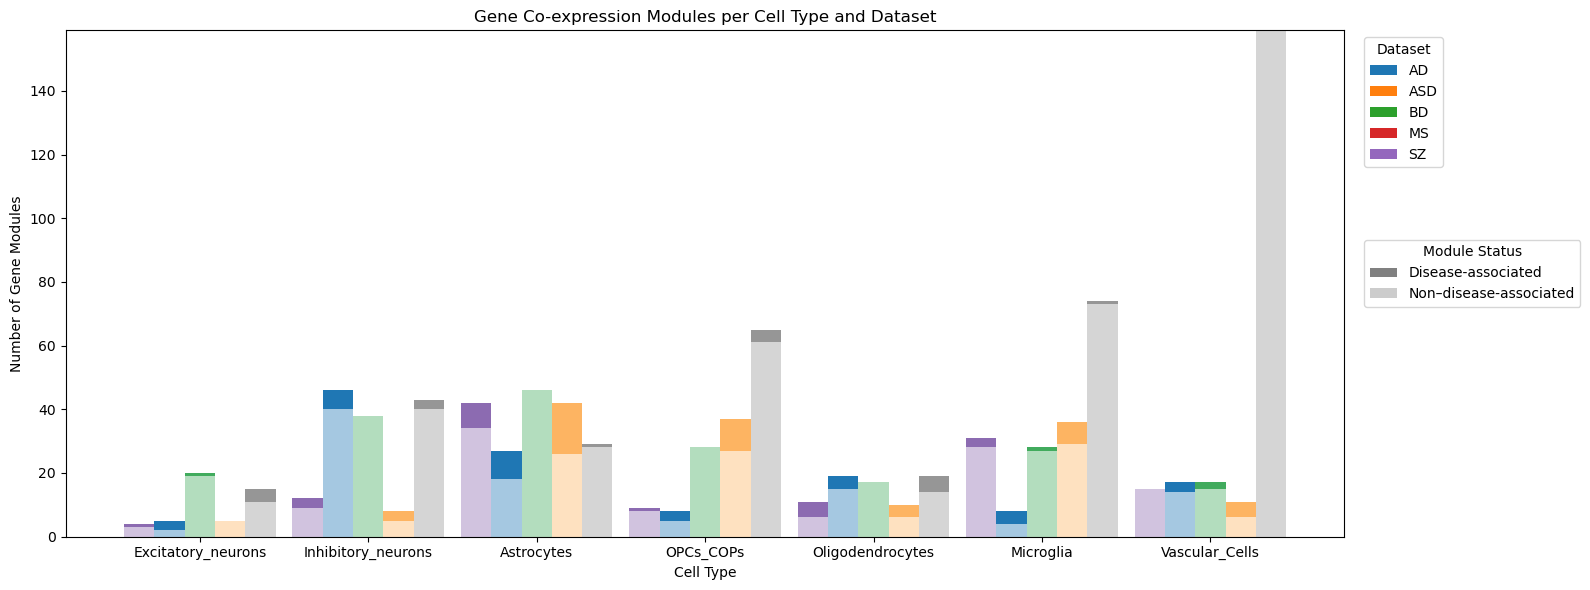

In [15]:
#Panel 2 B Barplot
plt.figure(figsize=(16, 6))

x=np.arange(len(celltype_order))
width=0.18  #bar width per dataset (change to 0.18 with BD)

palette=sns.color_palette("tab10", len(datasets_order))

for i, dataset in enumerate(datasets_order):
    subset=plot_df[plot_df["Dataset"]==dataset]
    bottom_vals=subset["Non-Disease Modules"].values
    top_vals=subset["Number of Disease-Associated Modules"].values
    color=dataset_colors[dataset]
    #non-disease-associated
    plt.bar(x + i * width,
        bottom_vals,
        width=width,
        color=color,
        alpha=0.4,
        label=f"{dataset} (non-disease)" if i==0 else None
    )

    #(disease-associated)
    plt.bar(
        x + i * width,
        top_vals,
        width=width,
        bottom=bottom_vals,
        color=color,
        alpha=1.0,
        label=f"{dataset} (disease)" if i==0 else None
    )

plt.xticks(x + width * (len(datasets_order) - 1) / 2, celltype_order, rotation=0, ha="center")
plt.xlabel("Cell Type")
plt.ylabel("Number of Gene Modules")
plt.title("Gene Co-expression Modules per Cell Type and Dataset")

# Custom legend
from matplotlib.patches import Patch

# Dataset legend (color-based)
dataset_handles=[
    Patch(facecolor=palette[i], label=datasets_order[i])
    for i in range(len(datasets_order))
]

# Stack meaning legend (alpha-based)
stack_handles=[
    Patch(facecolor="gray", alpha=1.0, label="Disease-associated"),
    Patch(facecolor="gray", alpha=0.4, label="Non–disease-associated")
]

# First legend: datasets
legend1=plt.legend(
    handles=dataset_handles,
    title="Dataset",
    loc="upper left",
    bbox_to_anchor=(1.01, 1)
)

# Second legend: stack meaning
legend2=plt.legend(
    handles=stack_handles,
    title="Module Status",
    loc="upper left",
    bbox_to_anchor=(1.01, 0.6)
)

plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig(FIG_DIR / "modules_by_celltype_dataset_barplot.pdf", bbox_inches="tight")
plt.show()

In [16]:
folder='/lab/solexa_sun/lab_members/sdavenport/scRNAseq/brain/co-expression_analysis/subtype_results/'

In [17]:
celltypes=['Oli_OPALIN', 'Exc_L4-5_RORB_IL1RAPL2', 'Oli_RASGRF1', 'Exc_L3-4_RORB_CUX2', 'Inh_ALCAM_TRPM3', 'Ast_GRM3', 'Exc_L3-5_RORB_PLCH1', 'Exc_L2-3_CBLN2_LINC02306', 'Exc_L6b', 'Exc_L6_THEMIS_NFIA', 'Mic_P2RY12', 'Ast_DPP10', 'OPC_DOCK5', 'Exc_L4-5_RORB_GABRG1', 'Inh_VIP_TSHZ2', 'Inh_L5-6_PVALB_STON2', 'Inh_PVALB_HTR4', 'Exc_L5-6_NP', 'Inh_PVALB_SULF1', 'Inh_LAMP5_NRG1_Rosehip', 'Opc_GRIA4', 'Inh_CUX2_MSR1', 'Exc_RELN_CHD7', 'Inh_VIP_ABI3BP', 'Exc_L5-6_RORB_LINC02196', 'Exc_NRGN', 'Exc_L6_CT', 'Inh_RYR3_TSHZ2', 'Inh_L3-5_SST_MAFB', 'capEndo', 'Inh_PVALB_CA8_Chandelier', 'Inh_FBN2_EPB41L4A', 'Inh_VIP_CLSTN2', 'Mic_DUSP1', 'Inh_L1-6_LAMP5_CA13', 'Exc_L5-6_IT_Car3', 'Inh_SGCD_PDE3A', 'Inh_ENOX2_SPHKAP', 'Inh_L1_PAX6_CA4', 'aSMC', 'Inh_SORCS1_TTN', 'Inh_GPC5_RIT2', 'Inh_LAMP5_RELN', 'Inh_L6_SST_NPY', 'Inh_PTPRK_FAM19A1', 'Fib2', 'Inh_VIP_THSD7B', 'Inh_L5-6_SST_TH', 'Inh_L1-2_PAX6_SCGN', 'Fib1', 'Mic_TPT1', 'Per1', 'aEndo', 'Opc_TPST1', 'CAMs', 'Exc_L5_ET', 'Ast_TPST1', 'vEndo', 'T_cells', 'Per2', 'vSMC', 'Mic_MKI67', 'Fib3']
#celltypes=['Exc_L4-5_RORB_IL1RAPL2']
datasets=['AD', 'ASD', 'MS', 'SZ'] #BD is being removed for now

c_df=pd.DataFrame(columns=["dataset", "celltype", "n_modules", "n_disease_modules"])
for dataset in datasets:
    for celltype in celltypes:
        #print(dataset, celltype)
        cur_modules=pd.read_csv(folder+dataset+'__'+celltype+'/modules/modules.csv')
        linear_cov=pd.read_csv(folder+dataset+'__'+celltype+'/'+dataset+'__'+celltype+'_module_covadjust.csv')
        try:
            ks=pd.read_csv(folder+dataset+'__'+celltype+'/module_geneexp_dist/'+dataset+'_KSstats.csv')
        except:
            ks=pd.DataFrame()
        try:
            fisher=pd.read_csv(folder+dataset+'__'+celltype+'/DEG_mod_association/'+dataset+'_fisherstats.csv')
        except:
            fisher=pd.DataFrame()
        cur_modules=cur_modules[['module']].drop_duplicates()
        if len(linear_cov)>0:
            linear_cov=linear_cov[['module', 'p_adj']].rename(columns={'p_adj': 'linear_p_adj'})
            merged=cur_modules.merge(linear_cov, on='module', how='left')
        else:
            merged['linear_p_adj']=100
        if len(ks)>0:
            ks=ks[['module', 'median_ks_pval', 'confidence']].rename(columns={'confidence': 'ks_confidence'})
            merged=merged.merge(ks, on='module', how='left')
        else:
            merged['median_ks_pval']=100
            merged['ks_confidence']=-1
        if len(fisher)>0:
            fisher=fisher[['module', 'p_adj']].rename(columns={'p_adj': 'fisher_p_adj'})
            merged=merged.merge(fisher, on='module', how='left')
        else:
            merged['fisher_p_adj']=100
        disease_modules=(merged[['linear_p_adj', 'median_ks_pval', 'fisher_p_adj']].lt(0.05)              # True / False for each test
                         .sum(axis=1)           # count significant tests per module
                         .ge(2)                 # True if >= 2 methods
                        ).sum()
        c_df.loc[len(c_df)]=[dataset, celltype, len(cur_modules.module.drop_duplicates()), disease_modules]

In [18]:
c_df

,dataset,celltype,n_modules,n_disease_modules
0,AD,Oli_OPALIN,8,3
1,AD,Exc_L4-5_RORB_IL1RAPL2,3,1
2,AD,Oli_RASGRF1,21,5
3,AD,Exc_L3-4_RORB_CUX2,3,0
4,AD,Inh_ALCAM_TRPM3,6,0
...,...,...,...,...
247,SZ,T_cells,0,0
248,SZ,Per2,0,0
249,SZ,vSMC,0,0
250,SZ,Mic_MKI67,0,0


In [19]:
c_df["celltype"]=c_df["celltype"].str.replace("_", " ", regex=False)
c_df

,dataset,celltype,n_modules,n_disease_modules
0,AD,Oli OPALIN,8,3
1,AD,Exc L4-5 RORB IL1RAPL2,3,1
2,AD,Oli RASGRF1,21,5
3,AD,Exc L3-4 RORB CUX2,3,0
4,AD,Inh ALCAM TRPM3,6,0
...,...,...,...,...
247,SZ,T cells,0,0
248,SZ,Per2,0,0
249,SZ,vSMC,0,0
250,SZ,Mic MKI67,0,0


In [20]:
plot_df=c_df.drop_duplicates().copy()
plot_df=plot_df.rename(columns={'n_modules':"Number of Modules", 'n_disease_modules':"Number of Disease-Associated Modules", 'dataset':'Dataset', 'celltype':'Cell Type'})
plot_df["Non-Disease Modules"]=(
    plot_df["Number of Modules"] -
    plot_df["Number of Disease-Associated Modules"]
)
plot_df=(
    plot_df
    .set_index(["Dataset", "Cell Type"])
    .reindex(
        pd.MultiIndex.from_product(
            [datasets_order, subtype_order],
            names=["Dataset", "Cell Type"]
        ),
        fill_value=0
    )
    .reset_index()
)

In [21]:
plot_df.to_csv("/lab/solexa_sun/lab_members/sdavenport/scRNAseq/brain/figures/panel2/modules_by_subtype_summary.csv")

In [22]:
def assign_celltype_class(celltype):
    '''
    Intended to be used to assign a dataset's original celltype definition into the AD dataset's broader
    celltype definitions.

    Apply with code such as this: 
    adata.obs['Celltype_Class']=adata.obs.apply(
    lambda row: sh.assign_celltype_class(row['Celltype']), axis=1
)
    '''
    if isinstance(celltype, str) and (celltype.lower().startswith("exc") or celltype.lower().startswith('ex-') or celltype.lower().startswith('exn')):
        return "Excitatory neurons"
    elif isinstance(celltype, str) and (celltype.lower().startswith("inh") or celltype.lower().startswith('in-') or celltype.lower().startswith('inn')):
        return "Inhibitory neurons"
    elif isinstance(celltype, str) and celltype.lower().startswith("ast"):
        return "Astrocytes"
    elif isinstance(celltype, str) and (celltype.lower().startswith("mic") or celltype.lower().startswith("mg") or celltype.lower()=='t cells' or celltype=='CAMs'):
        return "Microglia"
    elif isinstance(celltype, str) and (celltype.lower().startswith("oli") or celltype.lower().startswith("odc")):
        return "Oligodendrocytes"
    elif isinstance(celltype, str) and (celltype.lower().startswith('vas') or celltype.lower().startswith('endo') or celltype.lower().startswith('peri') or 
                                        celltype in ['Fib1','capEndo','aEndo','vEndo','aSMC','vSMC','Per2','Per1','Fib2','Fib3']):
        return "Vascular Cells"
    elif isinstance(celltype, str) and celltype.lower().startswith("opc"):
        return "OPCs + COPs"
    else:
        return celltype

In [23]:
plot_df['Cell Type Class']=plot_df.apply(
    lambda row: assign_celltype_class(row['Cell Type']), axis=1
)

In [24]:
subtype_summary_df=(plot_df.groupby(['Dataset','Cell Type Class'], as_index=False).agg({"Number of Modules": "sum", "Number of Disease-Associated Modules": "sum",
                                                                     "Non-Disease Modules": "sum"
                                                                    })
                   )

In [26]:
# exc_plot_df=plot_df[plot_df['Cell Type'].isin(Excitatory_neurons)]
# plot_sub_dfs={'Excitatory_neurons':exc_plot_df}
subtype_summary_df

,Dataset,Cell Type Class,Number of Modules,Number of Disease-Associated Modules,Non-Disease Modules
0,AD,Astrocytes,150,12,138
1,AD,Excitatory neurons,66,11,55
2,AD,Inhibitory neurons,220,14,206
3,AD,Microglia,619,6,613
4,AD,OPCs + COPs,271,4,267
5,AD,Oligodendrocytes,29,8,21
6,AD,Vascular Cells,1102,3,1099
7,ASD,Astrocytes,78,11,67
8,ASD,Excitatory neurons,698,17,681
9,ASD,Inhibitory neurons,3927,16,3911


In [28]:
datasets_order=['AD', 'ASD', 'BD', 'MS', 'SZ']

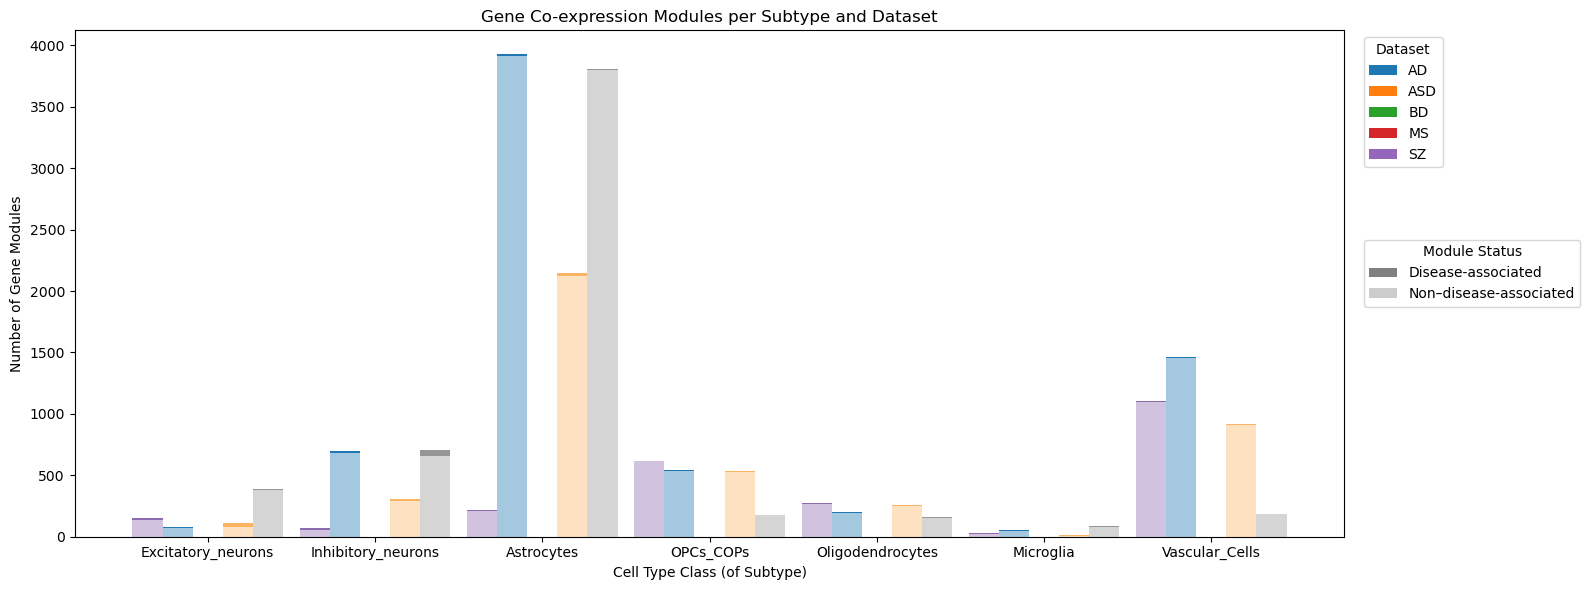

In [30]:
plt.figure(figsize=(16, 6))

x=np.arange(len(list(plot_df['Cell Type Class'].unique())))
width=0.18  #bar width per dataset (change to 0.18 with BD)

palette=sns.color_palette("tab10", len(datasets_order))

for i, dataset in enumerate(datasets_order):
    subset=subtype_summary_df[subtype_summary_df["Dataset"]==dataset]
    bottom_vals=subset["Non-Disease Modules"].values
    top_vals=subset["Number of Disease-Associated Modules"].values
    color=dataset_colors[dataset]
    
    #non-disease-associated
    plt.bar(x + i * width, bottom_vals, width=width, color=color, alpha=0.4, label=f"{dataset} (non-disease)" if i==0 else None)

    #(disease-associated)
    plt.bar(x + i * width, top_vals, width=width, bottom=bottom_vals, color=color, alpha=1.0, label=f"{dataset} (disease)" if i==0 else None)

plt.xticks(x + width * (len(datasets_order) - 1) / 2, celltype_order, rotation=0, ha="center")
plt.xlabel(f"Cell Type Class (of Subtype)")
plt.ylabel("Number of Gene Modules")
plt.title(f"Gene Co-expression Modules per Subtype and Dataset")

#legends
dataset_handles=[Patch(facecolor=palette[i], label=datasets_order[i]) for i in range(len(datasets_order))]
stack_handles=[Patch(facecolor="gray", alpha=1.0, label="Disease-associated"), Patch(facecolor="gray", alpha=0.4, label="Non–disease-associated")]
legend1=plt.legend(handles=dataset_handles, title="Dataset", loc="upper left", bbox_to_anchor=(1.01, 1))
legend2=plt.legend(handles=stack_handles, title="Module Status", loc="upper left", bbox_to_anchor=(1.01, 0.6))
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig(FIG_DIR / f"modules_by_subtype_dataset_barplot.pdf", bbox_inches="tight")
plt.show()